In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import operator
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns
import theano.tensor as tt
import warnings

from scipy.special import expit
from sklearn.metrics import confusion_matrix

%matplotlib inline

In [2]:
warnings.filterwarnings("ignore")

## Question 1

Generate synthetic from a mixture of three Gaussians. Check the accompanying Jupyter Notebook for this chapter for an example on how to do this. Fit a finite Gaussian mixture model with 2, 3, or 4 components.

In [3]:
locs = np.random.choice(np.linspace(1, 10, 10), size=3, replace=False)
scales = 10 ** np.random.choice(np.linspace(-2, 3, 6), size=3, replace=False)
locs, scales

(array([9., 4., 1.]), array([1.e+01, 1.e-01, 1.e+03]))

In [4]:
data_size = 100

g0 = stats.norm(loc=locs[0], scale=scales[0]).rvs(data_size)
g1 = stats.norm(loc=locs[1], scale=scales[1]).rvs(data_size)
g2 = stats.norm(loc=locs[2], scale=scales[2]).rvs(data_size)
y = g0 + g1 + g2

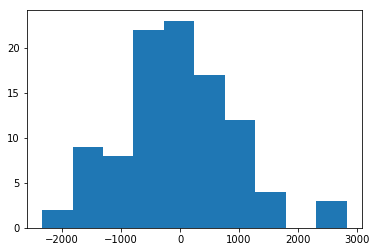

In [5]:
plt.hist(y)
_ = plt.show()

In [6]:
num_clusters = 2
with pm.Model() as model_mg_q1a:
    p = pm.Dirichlet('p', a=np.ones(num_clusters))
    means = pm.Normal('means', mu=y.mean(), sd=10, shape=num_clusters)
    sd = pm.HalfNormal('sd', sd=10)
    y_pred = pm.NormalMixture('y_pred', w=p, mu=means, sd=sd, observed=y)
    trace_mg_q1a = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:08<00:00, 454.68draws/s] 
The acceptance probability does not match the target. It is 0.8785953684507294, but should be close to 0.8. Try to increase the number of tuning steps.


In [7]:
num_clusters = 3
with pm.Model() as model_mg_q1b:
    p = pm.Dirichlet('p', a=np.ones(num_clusters))
    means = pm.Normal('means', mu=y.mean(), sd=10, shape=num_clusters)
    sd = pm.HalfNormal('sd', sd=10)
    y_pred = pm.NormalMixture('y_pred', w=p, mu=means, sd=sd, observed=y)
    trace_mg_q1b = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:09<00:00, 407.28draws/s] 


In [8]:
num_clusters = 4
with pm.Model() as model_mg_q1c:
    p = pm.Dirichlet('p', a=np.ones(num_clusters))
    means = pm.Normal('means', mu=y.mean(), sd=10, shape=num_clusters)
    sd = pm.HalfNormal('sd', sd=10)
    y_pred = pm.NormalMixture('y_pred', w=p, mu=means, sd=sd, observed=y)
    trace_mg_q1c = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:10<00:00, 370.56draws/s] 


## Question 2

Use WAIC and LOO to compare the results from exercise 1.

In [9]:
cmp_df = az.compare({
    "2_clusters": trace_mg_q1a,
    "3_clusters": trace_mg_q1b,
    "4_clusters": trace_mg_q1c
}, ic="waic")
cmp_df

,waic,pwaic,dwaic,weight,se,dse,warning
3_clusters,2362.89,9.6831,0,1,167.355,0,1
4_clusters,2363.68,9.79279,0.793866,0,167.569,0.228096,1
2_clusters,2364.64,9.53101,1.75626,7.66054e-15,167.678,0.324802,1


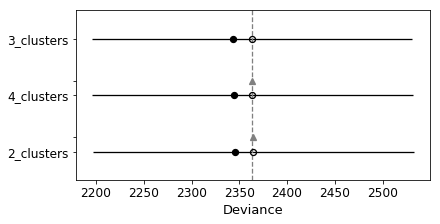

In [10]:
_ = az.plot_compare(cmp_df)

In [11]:
cmp_df = az.compare({
    "2_clusters": trace_mg_q1a,
    "3_clusters": trace_mg_q1b,
    "4_clusters": trace_mg_q1c
}, ic="loo")
cmp_df

,loo,ploo,dloo,weight,se,dse,warning
3_clusters,2362.97,9.72548,0,1,167.388,0,0
4_clusters,2363.82,9.86376,0.851033,1.05471e-15,167.629,0.259447,1
2_clusters,2364.48,9.44932,1.50813,0,167.6,0.224238,0


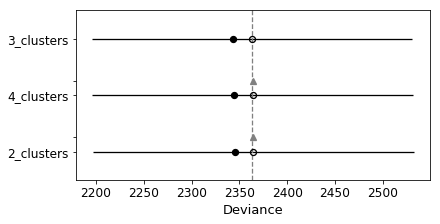

In [12]:
_ = az.plot_compare(cmp_df)

## Question 3

Read and run the following examples about mixture models from the [PyMC3 documentation](https://docs.pymc.io/nb_examples/index.html):

* [Marginalized Gaussian Mixture Model](https://docs.pymc.io/notebooks/marginalized_gaussian_mixture_model.html).
* [Dependent density regression](https://docs.pymc.io/notebooks/dependent_density_regression.html)
* [Gaussian Mixture Model with ADVI](https://docs.pymc.io/notebooks/gaussian-mixture-model-advi.html) (you will find more information about ADVI in Chapter 8, Inference Engines).

## Question 4

Repeat exercise 1 using a Dirichlet process.

<p><font color="blue"><p>Dirichlet Process involves the idea of stick breaking, that the mixture is composed of infinite/unknown number of distributions, and can be approximated with the stick breaking process. So there is no need to try to figure out the optimum number of clusters unlike in mixture models. Plot of w vs K below shows that K=20 serves as a good approximation for K -> &infin; </p></font></p>

In [13]:
N = len(y)
K = 20

def stick_breaking(alpha):
    beta = pm.Beta("beta", 1., alpha, shape=K)
    w = beta * pm.math.concatenate([[1.],
    tt.extra_ops.cumprod(1. - beta)[:-1]])
    return w

with pm.Model() as model_q4:
    alpha = pm.Gamma("alpha", 1., 1.)
    w = pm.Deterministic('w', stick_breaking(alpha))
    
    means = pm.Normal('means', mu=y.mean(), sd=10, shape=K)
    sd = pm.HalfNormal('sd', sd=10, shape=K)

    y_pred = pm.NormalMixture("y_pred", w, means, sd=sd, observed=y)
    
    trace_q4 = pm.sample(1000, tune=3000, nuts_kwargs={'target_accept': 0.9})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, beta, alpha]
Sampling 4 chains: 100%|██████████| 16000/16000 [01:41<00:00, 157.00draws/s]
There were 601 divergences after tuning. Increase `target_accept` or reparameterize.
There were 256 divergences after tuning. Increase `target_accept` or reparameterize.
The chain contains only diverging samples. The model is probably misspecified.
There were 974 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


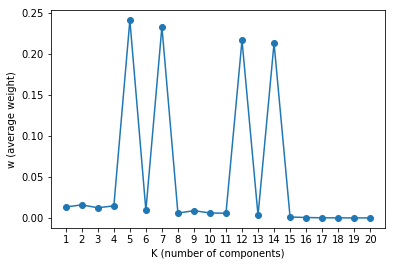

In [14]:
xs = np.arange(K)
ys = trace_q4["w"].mean(axis=0)
plt.plot(xs, ys, marker="o")
plt.xticks(xs, xs+1)
plt.xlabel("K (number of components)")
plt.ylabel("w (average weight)")
_ = plt.show()

In [15]:
ypred_pps = pm.sample_posterior_predictive(trace_q4, 200, model=model_q4)["y_pred"]
ypred_pps = ypred_pps.reshape(-1)
ypred_pps.shape

100%|██████████| 200/200 [00:00<00:00, 866.52it/s]


(20000,)

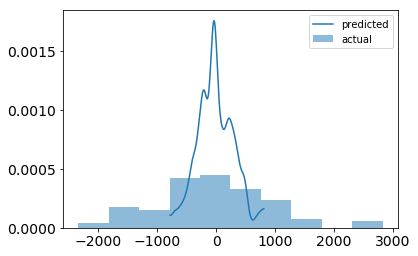

In [16]:
plt.hist(y, alpha=0.5, normed=True, label="actual")
az.plot_kde(ypred_pps, label="predicted")
plt.legend(loc="best")
_ = plt.show()

## Question 5

Assuming for a moment that you do not know the correct species/labels for the Iris dataset, use a mixture model to cluster the three iris species, using one feature of your choice (like the length of the sepal).

<p><font color="blue"><p>We create a mixture model of 3 clusters (we know that there are 3 clusters from histogram of the data distribution, but we don't know which record belongs to which of the 3 clusters. The mixture model gives us 3 component normal distributions identified by (mean, sd). For each data point, we will compute the PDF against each normal distribution, i.e., the probability of it belonging to each distribution. We will assign to each point the id of the distribution for which it has the highest probability of belonging.</p></font></p>

In [17]:
iris_df = pd.read_csv("../BAP/code/data/iris.csv")
iris_df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [18]:
y = iris_df["sepal_length"].values
y.shape

(150,)

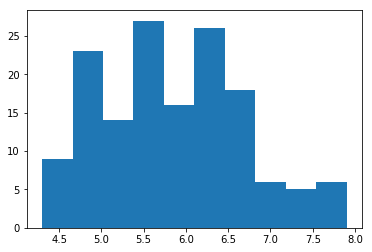

In [19]:
_ = plt.hist(y)

In [20]:
num_clusters = 3
with pm.Model() as model_mg_q5:
    p = pm.Dirichlet('p', a=np.ones(num_clusters))
    means = pm.Normal('means', mu=y.mean(), sd=10, shape=num_clusters)
    sd = pm.HalfNormal('sd', sd=10)
    y_pred = pm.NormalMixture('y_pred', w=p, mu=means, sd=sd, observed=y)
    trace_mg_q5 = pm.sample(tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:19<00:00, 300.85draws/s]
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.09025253636321735, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9165877760820373, but should be close to 0.8. Try to increase the number of tuning steps.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.45132053859343074, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


In [21]:
az.summary(trace_mg_q5, var_names=["means"])

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
means[0],5.93,1.65,0.42,3.19,7.49,6.0,1.30
means[1],6.00,1.17,0.12,4.92,7.43,49.0,1.04
means[2],6.40,2.48,0.19,4.91,7.78,45.0,1.01


In [22]:
means = np.mean(trace_mg_q5["means"], axis=0)
stds = np.std(trace_mg_q5["means"], axis=0)
dist_props = [(means[0], stds[0], 0), 
              (means[1], stds[1], 1), 
              (means[2], stds[2], 2)]

cid_dists = [(cid, stats.norm(loc=mean, scale=sd)) for mean, sd, cid in dist_props]
cid_preds = []
for sl in y:
    cid = sorted([(cid, dist.pdf(sl)) for cid, dist in cid_dists],
                 key=operator.itemgetter(1),
                 reverse=True)[0][0]
    cid_preds.append(cid)
    
iris_df["cluster_id"] = cid_preds
iris_df.head()

,sepal_length,sepal_width,petal_length,petal_width,species,cluster_id
0,5.1,3.5,1.4,0.2,setosa,1
1,4.9,3.0,1.4,0.2,setosa,1
2,4.7,3.2,1.3,0.2,setosa,1
3,4.6,3.1,1.5,0.2,setosa,0
4,5.0,3.6,1.4,0.2,setosa,1


In [23]:
species2cid = { "setosa": 0, "versicolor": 1, "virginica": 2 }
y_true = [species2cid[x] for x in iris_df["species"].values]
y_pred = iris_df["cluster_id"].values
confusion_matrix(y_true, y_pred)

array([[ 9, 41,  0],
       [ 0, 50,  0],
       [ 1, 44,  5]])

## Question 6

Repeat exercise 5 but this time use two features.

<p><font color="blue">
    <p>Custom Mixture distributions such as NormalMixture seem to be defined only for univariate distributions. For multivariate, we need to replace the Normal prior with the MvNormal. We have built this model as a Dirichlet mixture of 3 MvNormal models.</p>
    <p>On the prediction side, we assume that the features are independent, and compute the cluster membership using the joint probability (product of PDFs) of the (sepal_length, sepal_width) point being part of a given cluster.</p>
</font></p>

In [24]:
y = iris_df[["sepal_length", "sepal_width"]].values
y.shape

(150, 2)

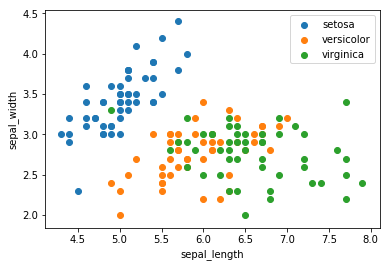

In [25]:
y_c0 = iris_df[iris_df["species"] == "setosa"][["sepal_length", "sepal_width"]].values
y_c1 = iris_df[iris_df["species"] == "versicolor"][["sepal_length", "sepal_width"]].values
y_c2 = iris_df[iris_df["species"] == "virginica"][["sepal_length", "sepal_width"]].values

plt.scatter(y_c0[:, 0], y_c0[:, 1], label="setosa")
plt.scatter(y_c1[:, 0], y_c1[:, 1], label="versicolor")
plt.scatter(y_c2[:, 0], y_c1[:, 1], label="virginica")
plt.legend(loc="best")
plt.xlabel("sepal_length")
plt.ylabel("sepal_width")
_ = plt.show()

In [26]:
num_clusters = 3
with pm.Model() as model_q6:
    p = pm.Dirichlet('p', a=np.ones(num_clusters))
    
    cov = np.array([[1., 0.5], [0.5, 2]])
    component0 = pm.MvNormal("c0_means", mu=y.mean(axis=0), cov=cov, shape=2)
    component1 = pm.MvNormal("c1_means", mu=y.mean(axis=0), cov=cov, shape=2)
    component2 = pm.MvNormal("c2_means", mu=y.mean(axis=0), cov=cov, shape=2)
    
    w = pm.Dirichlet("w", a=np.ones((3,)))
    sd = pm.HalfNormal('sd', sd=10)
    mix = pm.Mixture("mix_means", w=w, 
                     comp_dists=[component0.distribution, component1.distribution, component2.distribution],
                     shape=2)
    obs = pm.Normal("y_pred", mu=mix, sd=sd, observed=y)
    trace_q6 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mix_means, sd, w, c2_means, c1_means, c0_means, p]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:23<00:00, 169.55draws/s]


In [27]:
az.summary(trace_q6, var_names=["c0_means", "c1_means", "c2_means"])

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
c0_means[0],5.86,0.99,0.02,3.87,7.66,3356.0,1.0
c0_means[1],3.07,1.43,0.01,0.39,5.72,3319.0,1.0
c1_means[0],5.83,0.97,0.02,4.00,7.55,4066.0,1.0
c1_means[1],3.01,1.36,0.02,0.65,5.77,3780.0,1.0
c2_means[0],5.83,0.99,0.02,4.04,7.59,3710.0,1.0
c2_means[1],3.05,1.42,0.03,0.52,5.75,3261.0,1.0


In [28]:
dist_props = [
    (np.mean(trace_q6["c0_means"], axis=0), np.std(trace_q6["c0_means"], axis=0), 0),
    (np.mean(trace_q6["c1_means"], axis=0), np.std(trace_q6["c1_means"], axis=0), 1),
    (np.mean(trace_q6["c2_means"], axis=0), np.std(trace_q6["c2_means"], axis=0), 2),
]
cid_dists = [(cid, stats.norm(loc=means[0], scale=stds[0]), 
                   stats.norm(loc=means[1], scale=stds[1]))
            for means, stds, cid in dist_props]
cid_preds = []
for feats in y:
    sl, sw = feats[0], feats[1]
    jt_probs = [(cid, dist_sl.pdf(sl) * dist_sw.pdf(sw)) for cid, dist_sl, dist_sw in cid_dists]
    cid_pred = sorted(jt_probs, key=operator.itemgetter(1), reverse=True)[0][0]
    cid_preds.append(cid_pred)

iris_df["cluster_id_2"] = cid_preds
iris_df.head()

,sepal_length,sepal_width,petal_length,petal_width,species,cluster_id,cluster_id_2
0,5.1,3.5,1.4,0.2,setosa,1,1
1,4.9,3.0,1.4,0.2,setosa,1,1
2,4.7,3.2,1.3,0.2,setosa,1,1
3,4.6,3.1,1.5,0.2,setosa,0,1
4,5.0,3.6,1.4,0.2,setosa,1,1


In [29]:
y_pred2 = iris_df["cluster_id_2"].values
confusion_matrix(y_true, y_pred2)

array([[ 1, 49,  0],
       [ 1, 49,  0],
       [12, 38,  0]])